# Examination of the impacts of taking a multi model ensemble mean for MIROC; Feb 2024

In [2]:
%reset -f

In [3]:
%load_ext autoreload

In [4]:
%reload_ext autoreload
%autoreload 2

In [91]:
# analysis functions
import xarray as xr
import numpy as np
import pandas as pd

# plotting functions
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# systems functions
import os
from collections import defaultdict

# my own classes and functions
from GradTrendClasses import ModelInput, Trend, TrendPlotting, CalculateMMEGradient, CalculateObsGradient
from GradientProjectFunctions import CropTrendsDf, RemoveClimatology, DictToDf, TrendsDictFromFiles, CalculateTrendPercentile, FlagInRange

## Calculating the MM mean of the gradient (i.e., averaging the time series from the distinct inputs)

In [6]:
gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients'
gradientMean = CalculateMMEGradient(gradientsDir)

/home/hbyrne/miniconda3/envs/hb_1129/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
libtbb.so.2: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## Now running the trend class on it

In [7]:
trends = Trend(gradientMean).trends
trendsDf = Trend(gradientMean).trendsDf

## Plotting the trends

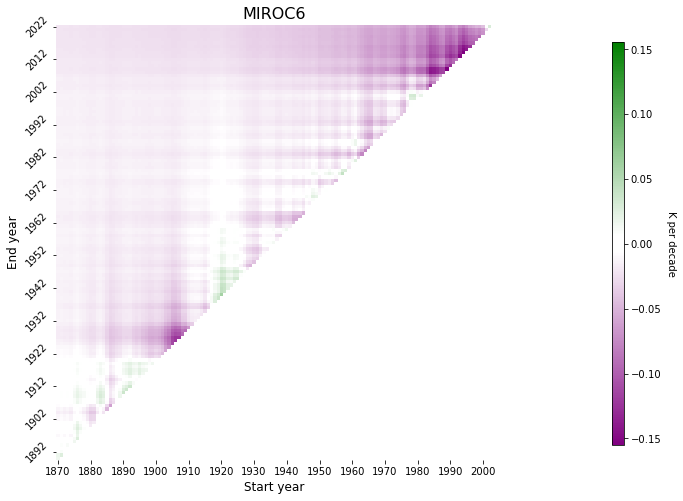

In [8]:
# cropping the trends Df so that plotting doesn't include deadspace
offset = 20 # years
trendsDfCrop = CropTrendsDf(trendsDf, offset)

# calculate the vmin and vmax
vmin = trendsDf.min().min()
vmax = trendsDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
# setting the colorbar
colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig = plt.figure(figsize = (8,8))
axesList = []

ax = fig.add_subplot(111)
ax.set_aspect('equal')
trendPlotter = TrendPlotting(trendsDfCrop, 'MIROC6', vmin, vmax, cmap, norm)
ax = trendPlotter.PlotTrends(ax)  
axesList.append(ax)

cbarAx = fig.add_axes([1.1, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('K per decade', rotation = 270, labelpad = 15)

plt.show()

# Observational dataset input and calculation

In [9]:
obsDir = '/home/hbyrne/Research/QMDA_2023'
fileName = 'HadISST_sst 2.nc'
os.chdir(obsDir)

In [10]:
# running the classes on it
modelInput = ModelInput(fileName)

# have to roll the coordinates for Hadley
modelInput = modelInput.ds.assign_coords(lon = ((360 + (modelInput.ds.lon % 360)) % 360))
modelInput = modelInput.roll(lon = int(len(modelInput['lon']) / 2), roll_coords = True)

# remove climatology
modelInput = RemoveClimatology(modelInput)

# calculate the gradient
gradient = CalculateObsGradient(modelInput, 'HadleyISST')

# calculate the trend
trends = Trend(gradient).trends
trendsDf = Trend(gradient).trendsDf

## Plotting the trends

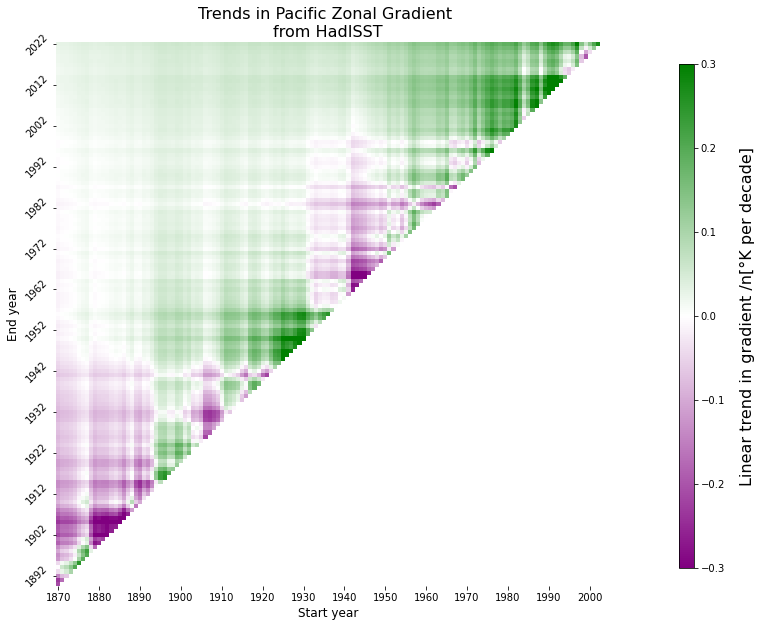

In [46]:
# the Had data has end dates that start at 1870 and start dates up to 2022; cropping so that we don't include those in the plot
# cropping the trends Df so that plotting doesn't include deadspace
offset = 20 # years
trendsDf = CropTrendsDf(trendsDf, offset)

# calculate the vmin and vmax
vmin = trendsDf.min().min()
vmax = trendsDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
vmin = -0.3
vmax = -vmin
    
# setting the colorbar
colors = [(0,'purple'), (0.50,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig = plt.figure(figsize = (10,10))
axesList = []

ax = fig.add_subplot(111)
ax.set_aspect('equal')
trendPlotter = TrendPlotting(trendsDf, 'Trends in Pacific Zonal Gradient \nfrom HadISST', vmin, vmax, cmap, norm)
ax = trendPlotter.PlotTrends(ax)  
axesList.append(ax)

cbarAx = fig.add_axes([1, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Linear trend in gradient /n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

plt.show()

# Calculating distributions of trends for each start and end date, plotting obs versus that

In [12]:
trendsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Trends'
os.chdir(trendsDir)

In [76]:
# create a dictionary with all of the trends from this directory
trendsDict = TrendsDictFromFiles(trendsDir)

In [85]:
# create dictionaries with lower and upper percentiles from the distribution of trends
dictLower, dictUpper = CalculateTrendPercentile(trendsDict, 2.5, 97.5)

In [93]:
# flagging everywhere that the values lie within the range of the models
dictObsInRange = FlagInRange(dictLower, dictUpper, trends)

In [94]:
# creating a dataframe
dfObsInRange = DictToDf(dictObsInRange)

# removing the bottom 20 rows so that this stippling df has the same dimensions as the observations
keepRows = [row for row in dfObsInRange.index if row >= 1890]
dfObsInRange = dfObsInRange.loc[keepRows, :]

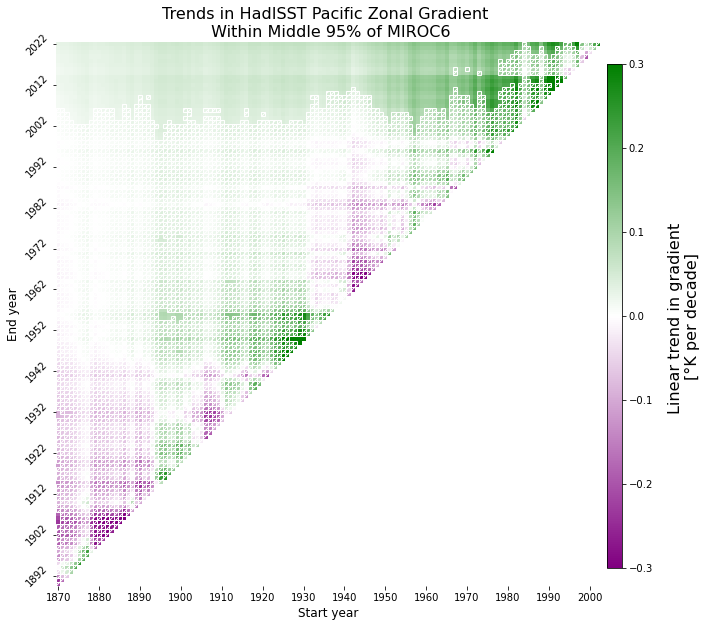

In [95]:
# plotting a better overlapping map (i.e., with stippling)

# starting with the observational plots

# calculate the vmin and vmax
vmin = trendsDf.min().min()
vmax = trendsDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
vmin = -0.3
vmax = -vmin
    
# setting the colorbar
colors = [(0,'purple'), (0.50,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)
ax.set_aspect('equal')
plot = sns.heatmap(trendsDf, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
plt.xticks(rotation=0)
plt.yticks(rotation=45)
title = 'Trends in HadISST Pacific Zonal Gradient \n Within Middle 95% of MIROC6'
plt.title(title, fontsize = 16)
plt.ylabel('End year', fontsize = 12)
plt.xlabel('Start year', fontsize = 12)

cbarAx = fig.add_axes([0.9, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Linear trend in gradient \n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

# adding the stippling with a for loop
for i, row in enumerate(dfObsInRange.values):
    for j, value in enumerate(row):
        if value == 1:
            plot.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='white', hatch='////'))

plt.show()